In [5]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import root_mean_squared_error 

np.random.seed(0)

In [6]:
#Class: RNN
class RNN(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
    
    #Input must be torch.Tensor and normalized
    def forward(self, input, h0):
        #h0 = self.initHidden()
        h_list, hn = self.i2h(input, h0)
        output_list = self.h2o(h_list)
        return output_list

In [7]:
#Class : LSTM
class LSTM(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    
    #Input must be torch.Tensor and normalized
    def forward(self, input, h0, c0):
        h_list, (hn,cn) = self.i2h(input, (h0, c0))
        output_list = self.h2o(h_list)
        return output_list

In [8]:
#Import et preprocessing
path = "C:/Users/Utilisateur/Documents/ENSAE/Stage/simulation/simulation.csv"
dataset = pd.read_csv(path)
[['x1', 'x2', 'x3', 'x4', 'x5', "x6", 'x7', 'x8', 'y_obs', 'y+1']]
dataset['y+1'] = dataset.groupby("individus")['y_obs'].shift(-1)
dataset_norm = dataset.copy()
dataset_norm = dataset_norm.dropna()
individus = dataset_norm.groupby('individus')[['x1', 'x2', 'x3', 'x4', 'x5', "x6", 'x7', 'y_obs', 'y+1']]
min, max = individus.transform('min'), individus.transform('max')
dataset_norm[['x1', 'x2', 'x3', 'x4', 'x5', "x6", 'x7', 'y_obs', 'y+1']] = (dataset_norm[['x1', 'x2', 'x3', 'x4', 'x5', "x6", 'x7', 'y_obs', 'y+1']] - min) / (max - min)

data_train = dataset_norm[dataset_norm['individus']<=400]
data_test = dataset_norm[dataset_norm['individus']>400]

groupby = data_train.groupby('individus')[['x1', 'x2', 'x3', 'x4', 'x5', "x6", 'x7', 'x8', 'y_obs']].apply(np.array)
input_train = [torch.Tensor(x) for x in groupby]
input_train = torch.stack(input_train)
groupby = data_train.groupby('individus')[['y+1']].apply(np.array)
target_train = [torch.Tensor(x) for x in groupby]
target_train = torch.stack(target_train)

groupby = data_test.groupby('individus')[['x1', 'x2', 'x3', 'x4', 'x5', "x6", 'x7', 'x8', 'y_obs']].apply(np.array)
input_test = [torch.Tensor(x) for x in groupby]
input_test = torch.stack(input_test)
groupby = data_test.groupby('individus')[['y+1']].apply(np.array)
target_test = [torch.Tensor(x) for x in groupby]
target_test = torch.stack(target_test)

#seq_lens = [len(inp) for inp in groupby]
#input_padded = pad_sequence([torch.tensor(x) for x in groupby])
#input_pack_padded = pack_padded_sequence(input_padded, lengths=seq_lens)


In [9]:
#hyperparamètres
rnn = RNN(input_size = 9, hidden_size = 25, output_size=1)
criterion = torch.nn.MSELoss()
#SGD = Stochastic gradient descent, lr = learning rate
optimizer = torch.optim.SGD(rnn.parameters(), lr = 0.01)
epoch_rnn = 5000

In [10]:
#RNN: training
loss_track = []
for k in range(epoch_rnn):
    h0 = torch.zeros((1,400,25))
    y_pred = rnn(input=input_train, h0=h0)
    loss = criterion(y_pred, target_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_track.append(loss.item())
print("mean RMSE on train data: ", np.mean(np.sqrt(loss_track)))

mean RMSE on train data:  0.11038773647271576


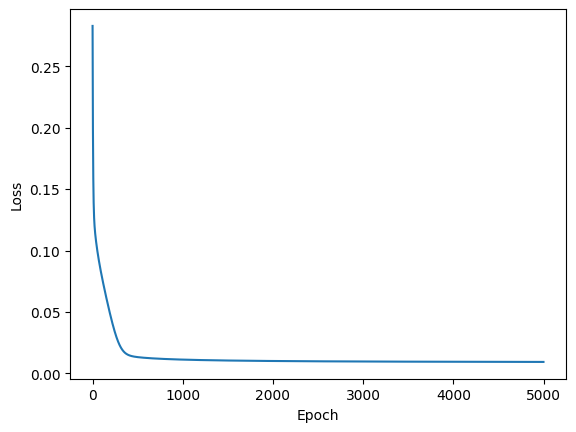

In [11]:
#plot loss rnn
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_track, label ="loss")
plt.legend
plt.show()

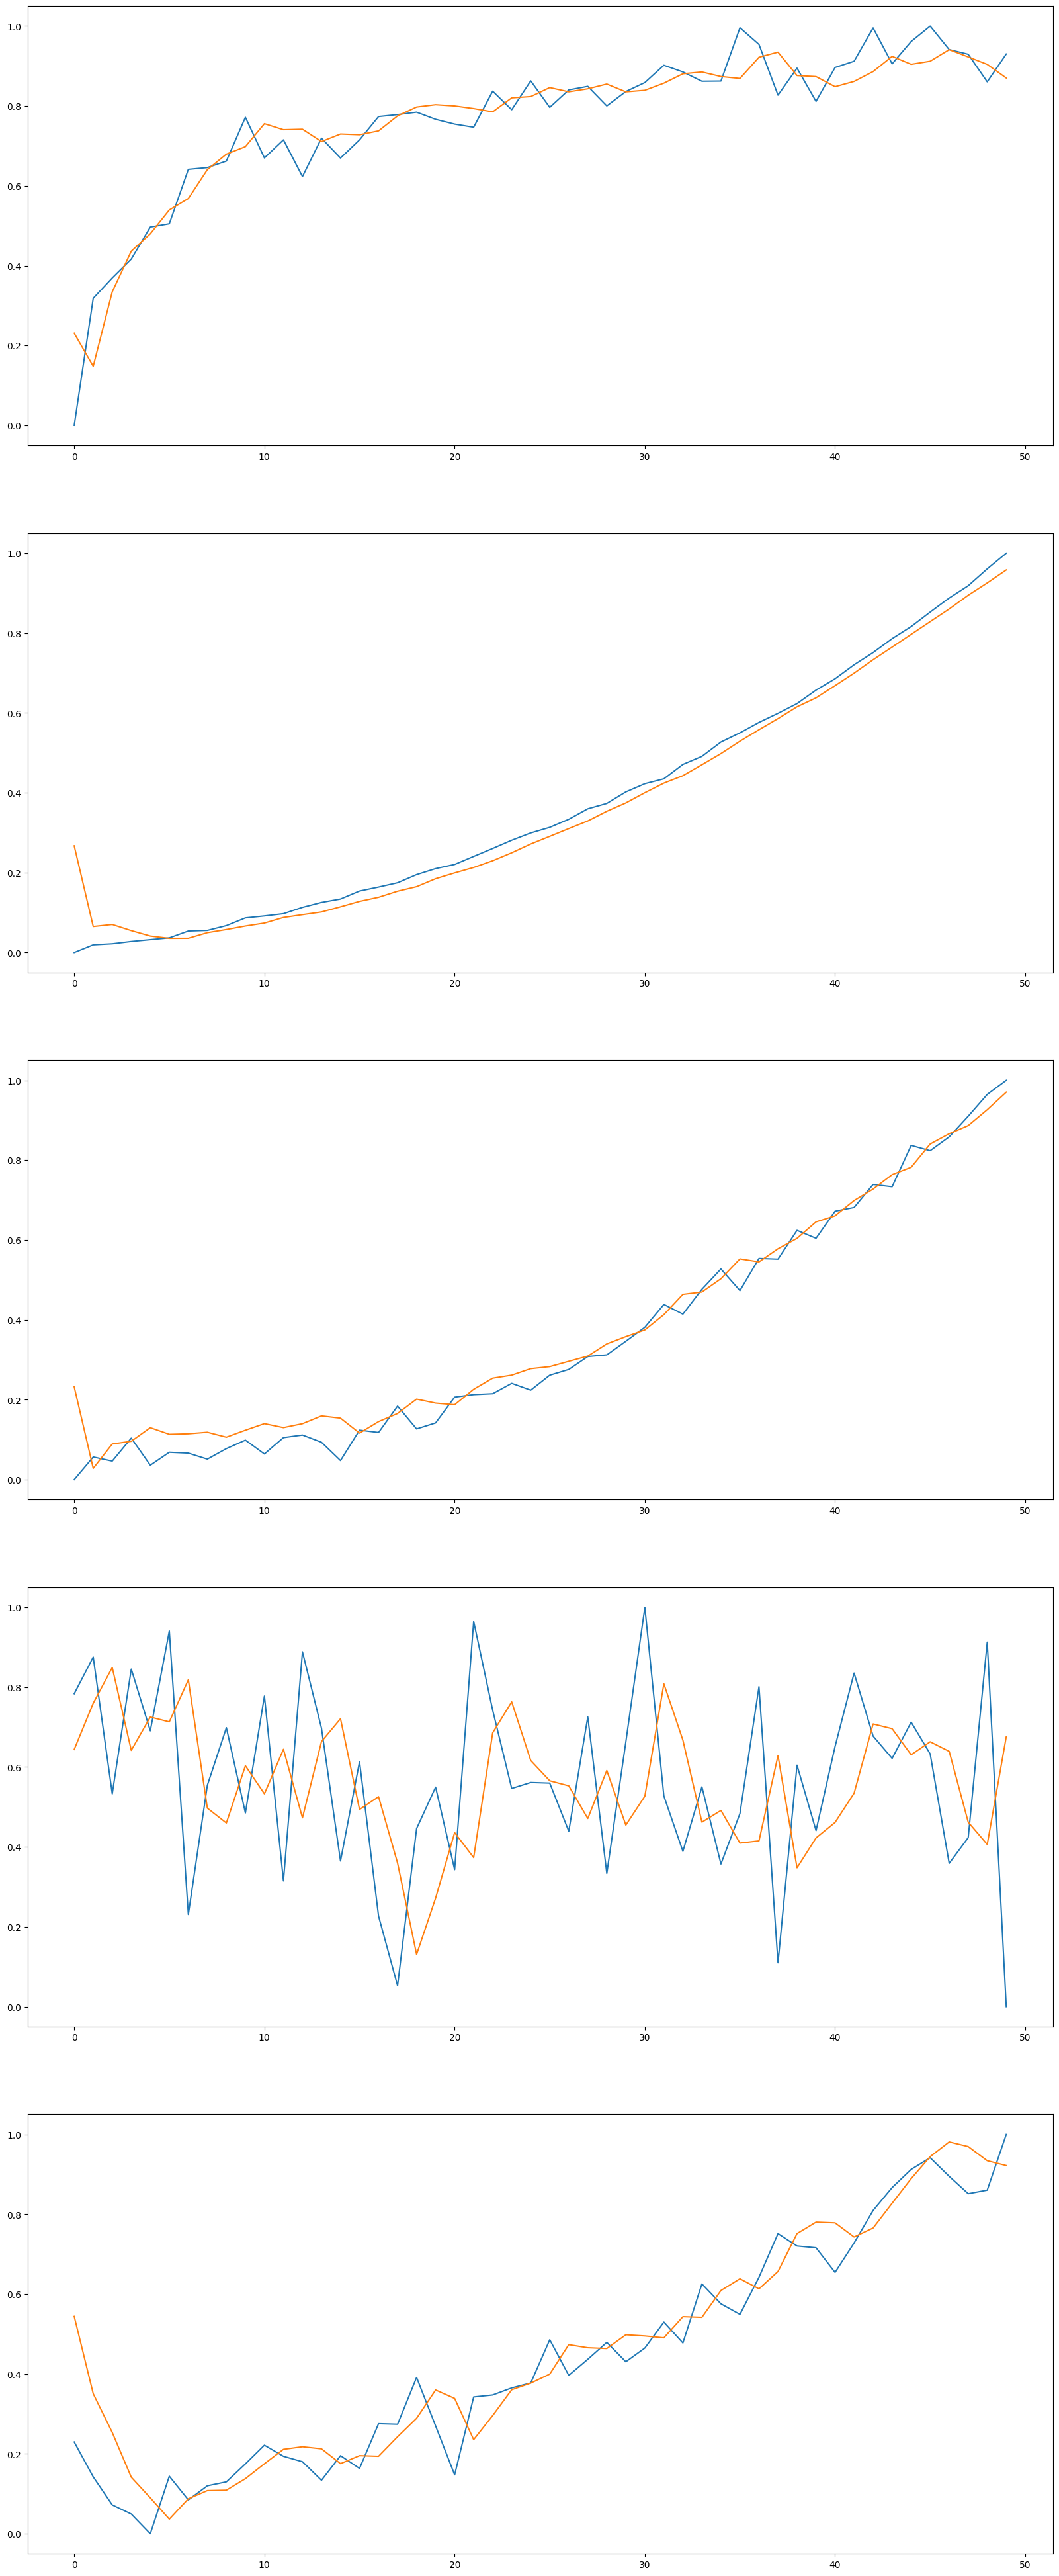

In [12]:
#RNN : plot 5 random curves from training data 
n = 5
ex = randint(1,400, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n):
    axs[k].plot(target_train[ex[k]].detach().numpy(), label= 'target')
    axs[k].plot(y_pred[ex[k]].detach().numpy(), label= 'prediction')
    axs[k].legend

In [13]:
#RNN: RMSE on test data
h0 = torch.zeros((1,100, 25))
y_pred = rnn(input_test, h0)
rmse_moy = 0
for k in range(len(y_pred)):
    rmse_moy+= root_mean_squared_error(y_pred[k].detach().numpy(), target_test[k].detach().numpy())
rmse_moy = rmse_moy/len(y_pred)
print("mean RMSE on test data: ", rmse_moy)

mean RMSE on test data:  0.09307569049298764


[(68, 0.06720501), (10, 0.036150735), (84, 0.0563946), (22, 0.037705977), (37, 0.10826993), (88, 0.03376376), (71, 0.12935463), (89, 0.04186901), (89, 0.04186901), (13, 0.21408613)]


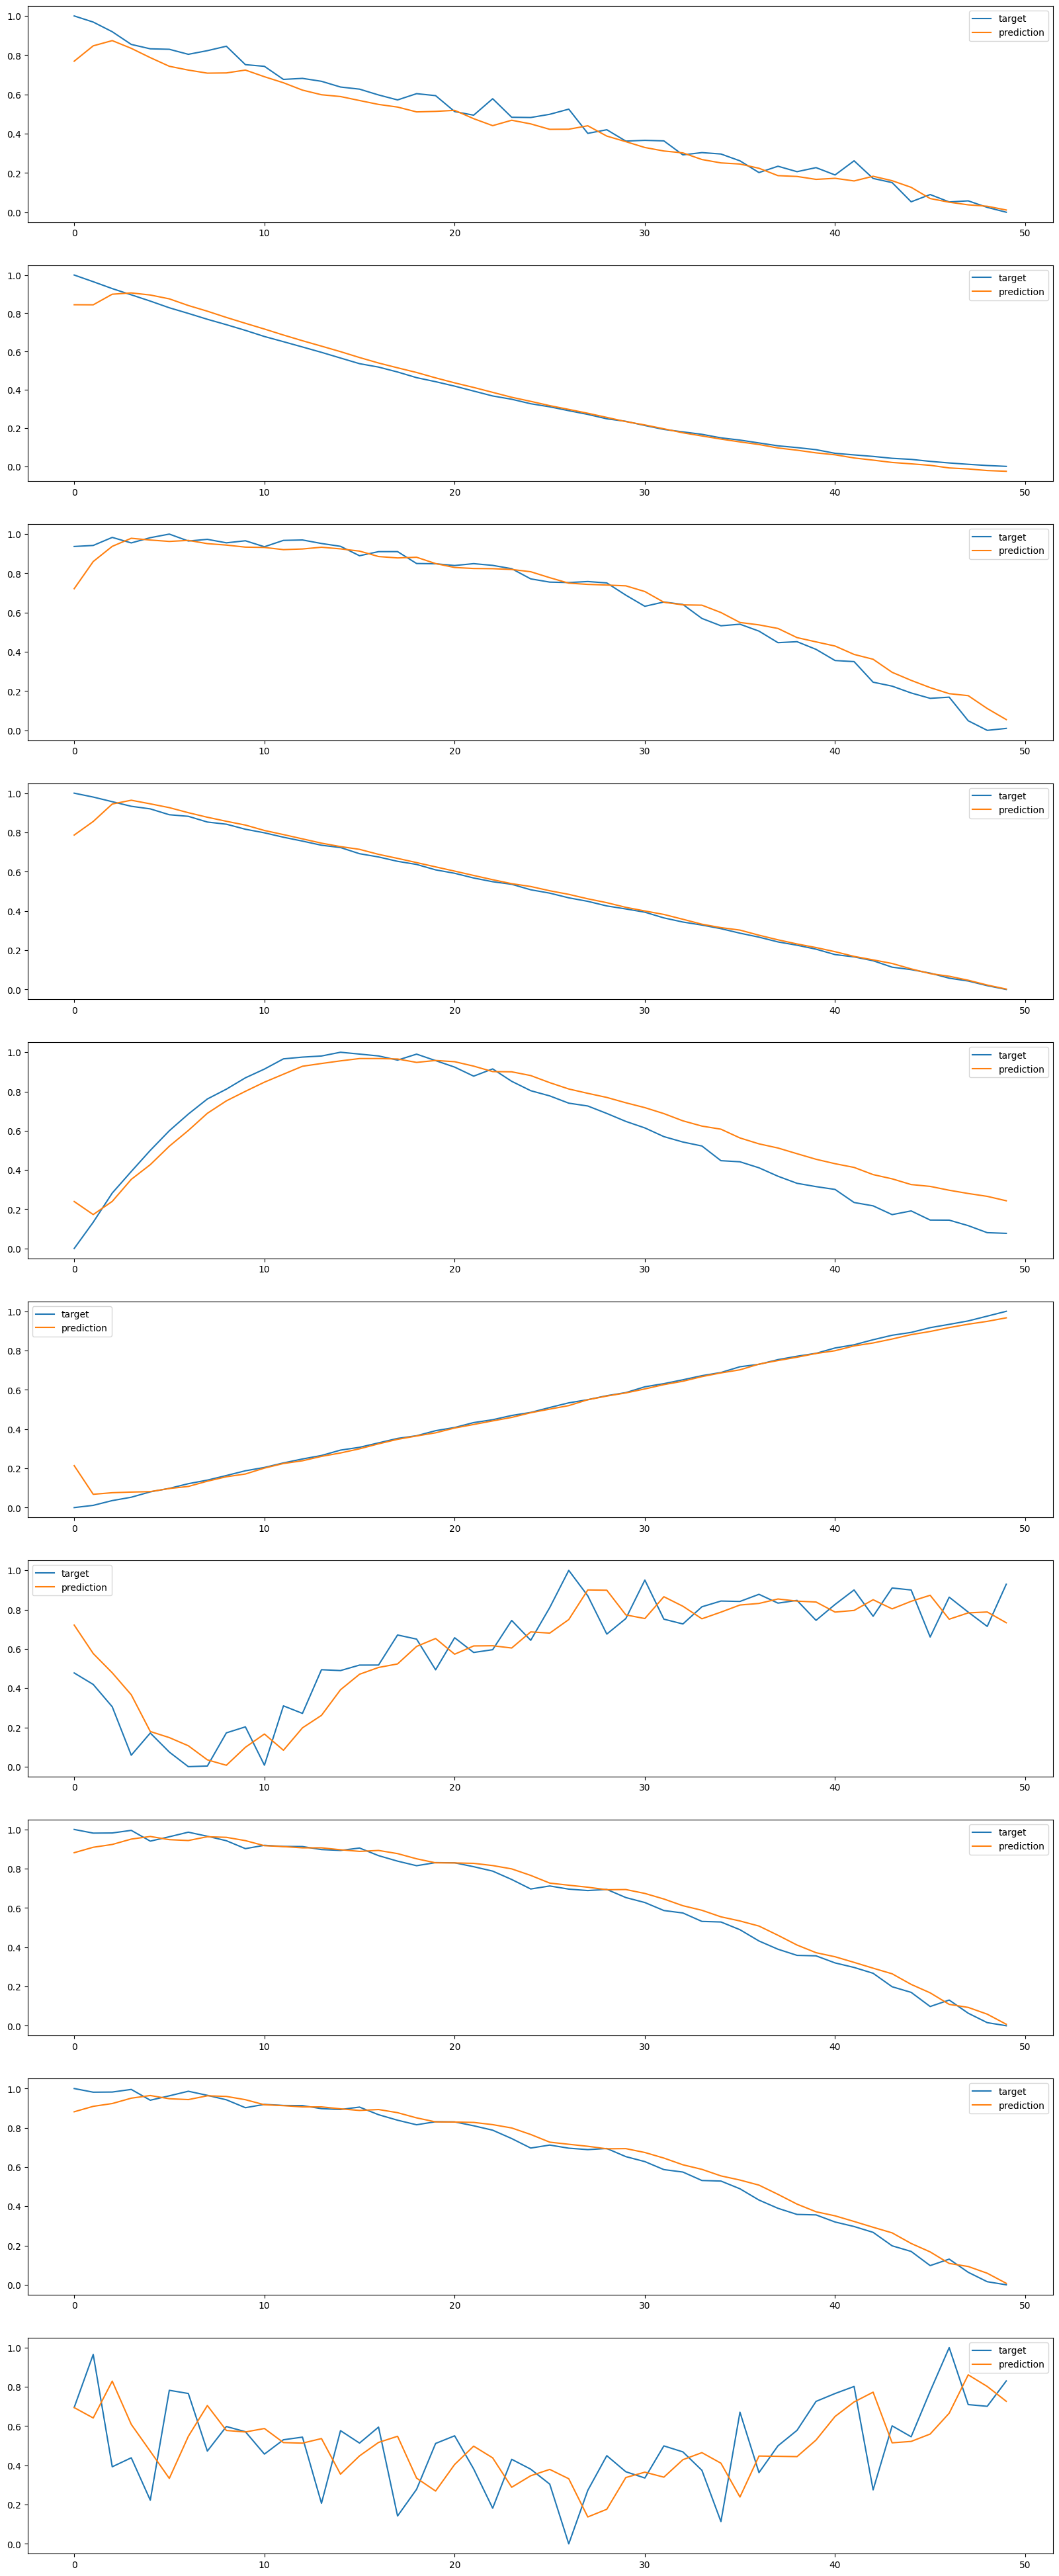

In [14]:
#RNN : plot 10 curves from test data
n = 10
ex = randint(1,100, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
res = []
for k in range(n):
    h0 = torch.zeros((1,25))
    y_pred = rnn(input_test[ex[k]], h0)
    res.append((ex[k], root_mean_squared_error(target_test[ex[k]].detach().numpy(), y_pred.detach().numpy())))
    axs[k].plot(target_test[ex[k]].detach().numpy(), label= 'target')
    axs[k].plot(y_pred.detach().numpy(), label= 'prediction')
    axs[k].legend()
print(res) #res contient les RMSE

In [15]:
#hyperparamètres
lstm = LSTM(input_size = 9, hidden_size = 25, output_size=1)
criterion = torch.nn.MSELoss()
#SGD = Stochastic gradient descent, lr = learning rate
optimizer = torch.optim.SGD(lstm.parameters(), lr = 0.01)
epoch_lstm = 5000

In [16]:
#LSTM: training
loss_track = []
for k in range(epoch_lstm):
    h0 = torch.zeros((1,400,25))
    c0 = torch.zeros((1,400,25)) 
    y_pred = lstm(input=input_train, h0=h0, c0 = c0)
    loss = criterion(y_pred, target_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_track.append(loss.item())
print("mean RMSE on train data: ", np.mean(np.sqrt(loss_track)))

mean RMSE on train data:  0.14879880901848588


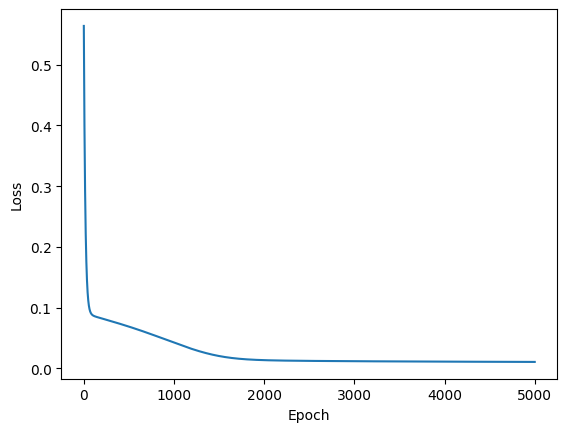

In [17]:
#plot loss lstm
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_track, label ="loss")
plt.legend
plt.show()

In [18]:
#LSTM: RMSE on test data
h0 = torch.zeros((1,100, 25))
c0 = torch.zeros((1,100, 25))
y_pred = lstm(input_test, h0, c0)
rmse_moy = 0
for k in range(len(y_pred)):
    rmse_moy+= root_mean_squared_error(y_pred[k].detach().numpy(), target_test[k].detach().numpy())
rmse_moy = rmse_moy/len(y_pred)
print("mean RMSE on test data: ", rmse_moy)

mean RMSE on test data:  0.10643014654517174


[(59, 0.08002921), (66, 0.07593927), (40, 0.07645598), (88, 0.051352777), (47, 0.11268784), (89, 0.08256619), (82, 0.07414366), (38, 0.23156054), (26, 0.0664536), (78, 0.25363436)]


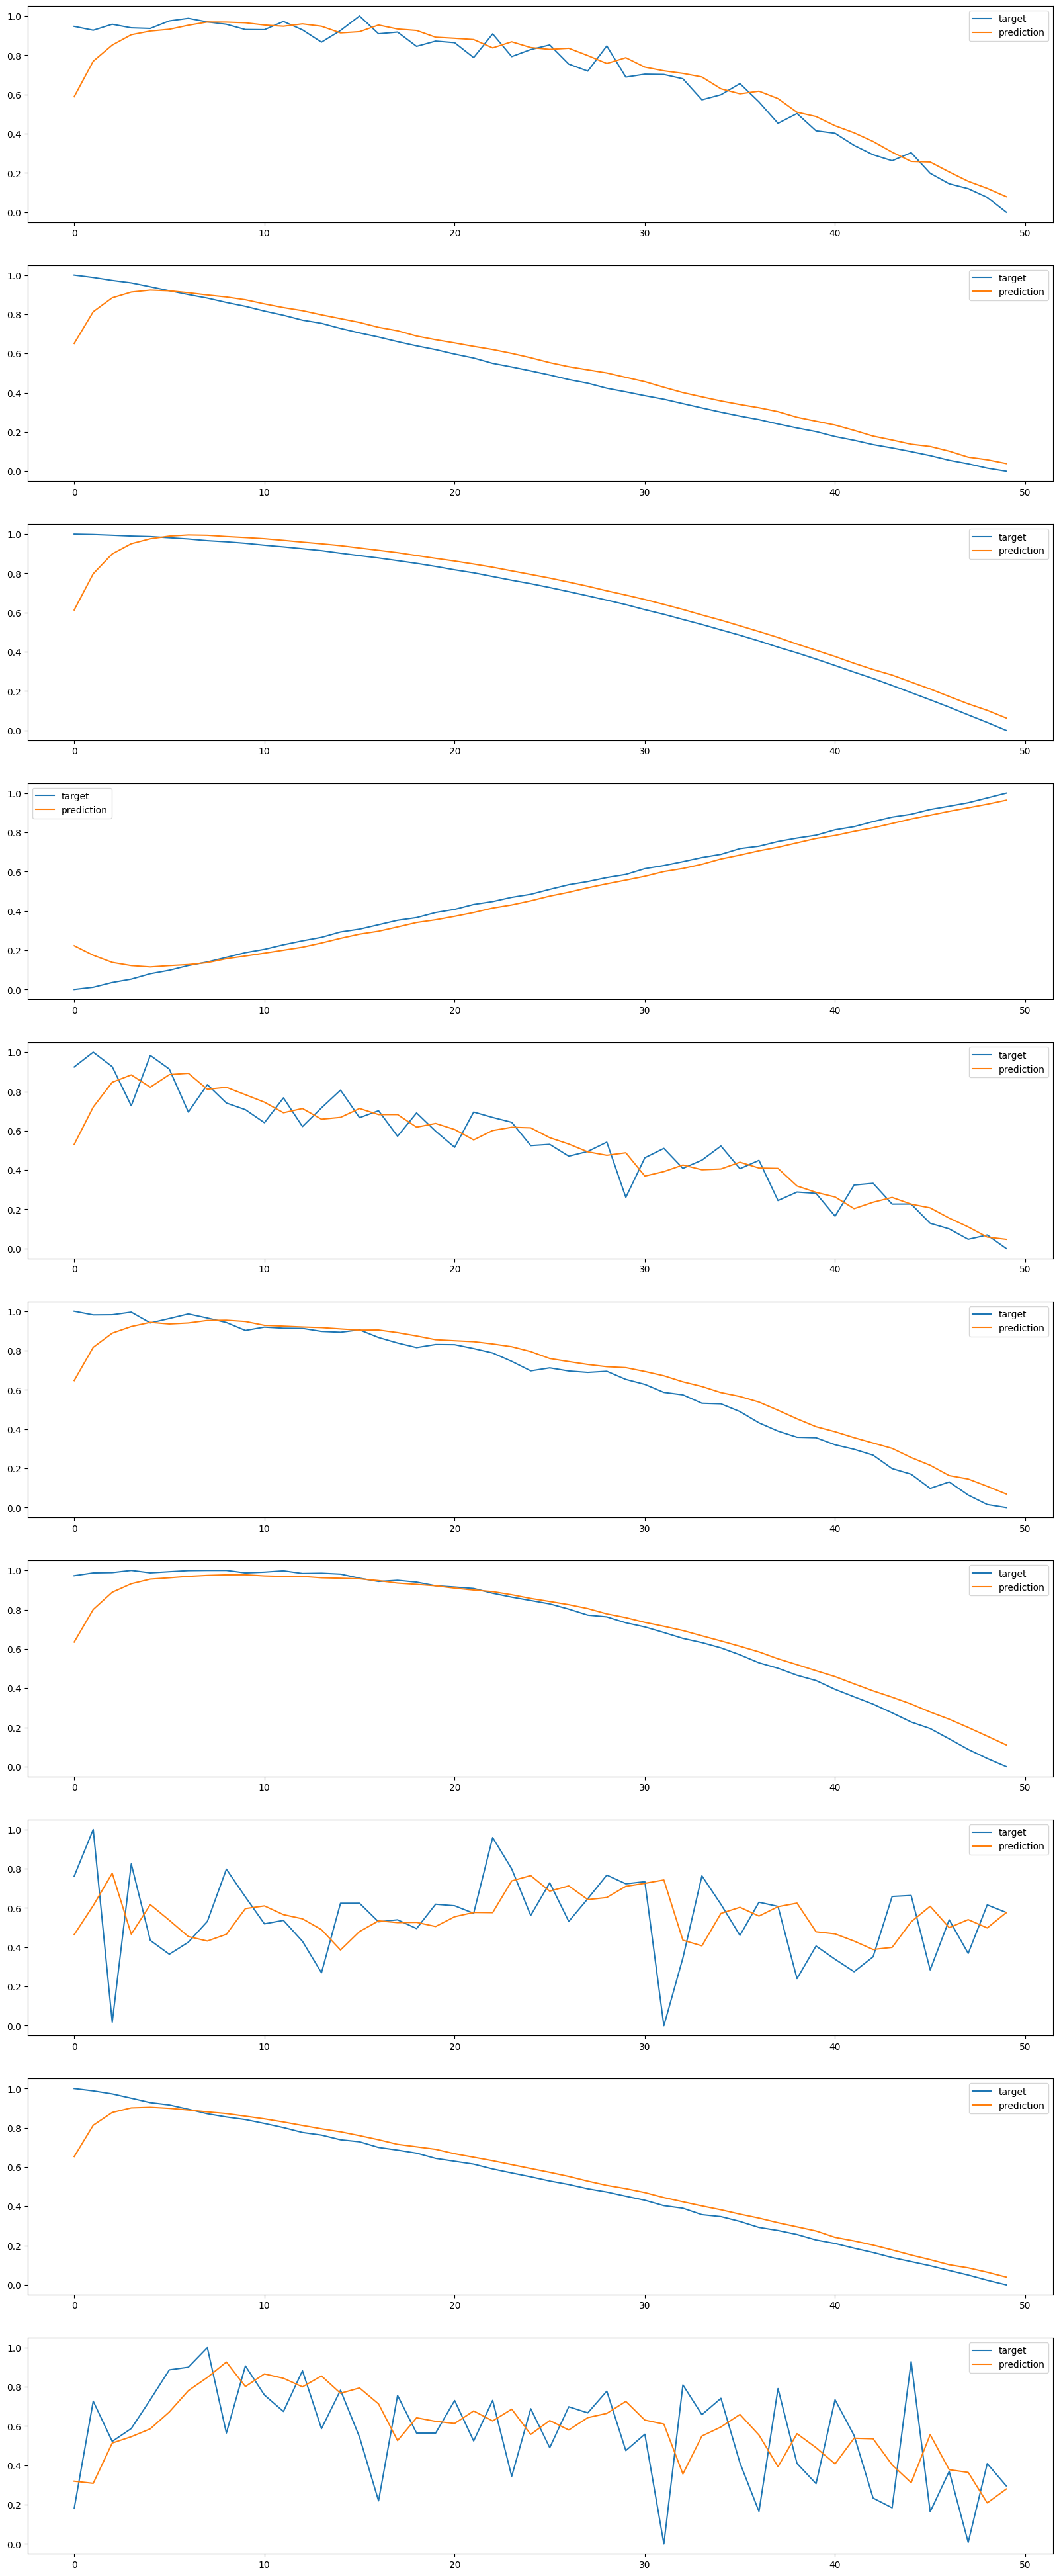

In [19]:
#LSTM : plot 10 curves from test data
n = 10
ex = randint(1,100, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
res = []
for k in range(n):
    h0 = torch.zeros((1,25))
    c0 = torch.zeros((1,25))
    y_pred = lstm(input_test[ex[k]], h0, c0)
    res.append((ex[k], root_mean_squared_error(target_test[ex[k]].detach().numpy(), y_pred.detach().numpy())))
    axs[k].plot(target_test[ex[k]].detach().numpy(), label= 'target')
    axs[k].plot(y_pred.detach().numpy(), label= 'prediction')
    axs[k].legend()
print(res) #res contient les RMSE